In [1]:
!pip install -U segmentation-models-pytorch albumentations --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 537.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 2.6 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=29303efad0ad8e277584c2c0369709a0b3acfd36393241539c8ec54256a6c798
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=0cb31acdb14f5aa1d20b373da23e37691a7653d65c7f425a1c40c94c49585bd5
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
# !pip uninstall -y segmentation-models-pytorch

In [3]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import segmentation_models_pytorch as smp
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [4]:
###Code to free gpu memory
# !pip install GPUtil

# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache() 

In [5]:
DATA_DIR = '/kaggle/input/ebhiseg/EBHI-SEG/'

In [6]:
from sklearn.model_selection import train_test_split
random_seed = 47
input_train = []
input_valid = []
input_test = []
target_train = []
target_valid = []
target_test = []
for x in ['Adenocarcinoma','High-grade IN','Low-grade IN','Normal','Polyp','Serrated adenoma']:
    inp = DATA_DIR + x + '/image'
    tar = DATA_DIR + x + '/label'
    inputs = os.listdir(inp)
    targets = os.listdir(tar)
    if x=='Low-grade IN':
        inputs.remove('GT2012149-2-400-001.png')
        inputs.remove('GTGT2012149-2-400-001.png')
    inputs = [(inp+'/'+z) for z in inputs]
    targets = [(tar+'/'+z) for z in targets]
    inputs_train, inputs_test = train_test_split(
    inputs,
    random_state=random_seed,
    train_size=0.8,
    shuffle=True)

    targets_train, targets_test = train_test_split(
    targets,
    random_state=random_seed,
    train_size=0.8,
    shuffle=True)
    
    inputs_train, inputs_valid = train_test_split(
    inputs_train,
    random_state=random_seed,
    train_size=0.5,
    shuffle=True)
    
    targets_train, targets_valid = train_test_split(
    targets_train,
    random_state=random_seed,
    train_size=0.5,
    shuffle=True)
    
    input_train.extend(inputs_train)
    input_valid.extend(inputs_valid)
    input_test.extend(inputs_test)
    target_train.extend(targets_train)
    target_valid.extend(targets_valid)
    target_test.extend(targets_test)
    

In [7]:
print(f' inputs train:{len(input_train)} inputs valid:{len(input_valid)} inputs test:{len(input_test)}')
print(f' targets train:{len(target_train)} targets valid:{len(target_valid)} targets test:{len(target_test)}')
print(input_train[0])

 inputs train:888 inputs valid:890 inputs test:448
 targets train:888 targets valid:890 targets test:448
/kaggle/input/ebhiseg/EBHI-SEG/Adenocarcinoma/image/GTxc2013512-1-400-005.png


In [8]:
input_train[0].split('/')[5]

'Adenocarcinoma'

In [9]:
target_test[0]

'/kaggle/input/ebhiseg/EBHI-SEG/Adenocarcinoma/label/GT2012165-1-400-001.png'

In [10]:
input_test[0]

'/kaggle/input/ebhiseg/EBHI-SEG/Adenocarcinoma/image/GT2012165-1-400-001.png'

In [11]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [12]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset


class Dataset(BaseDataset):
    """EBHI-SEG Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = {'Adenocarcinoma':0, 'High-grade IN':1, 'Low-grade IN':2, 'Normal':3, 'Polyp':4, 'Serrated adenoma':5}
    
    def __init__(
            self, 
            images_dir: list, 
            masks_dir: list, 
            augmentation=None, 
            preprocessing=None,
    ):
#         self.ids = os.listdir(images_dir)
        self.images_list = images_dir
        self.masks_list = masks_dir
        
        # convert str names to class values on masks
#         self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_list[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_list[i], 0)
        mask = mask.reshape(224,224,1)
        label = self.CLASSES[self.images_list[i].split('/')[5]]
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        mask[mask>0]=1
        return image, mask#, label
        
    def __len__(self):
        return len(self.images_list)


In [14]:
fn = cv2.cvtColor

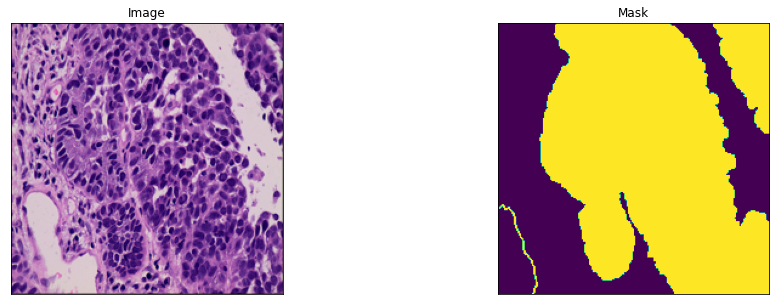

(224, 224, 3)

In [13]:
dataset = Dataset(input_train, target_train)

image, mask = dataset[269] # get some sample
visualize(
    image=image, 
    mask=mask.squeeze(),
)
image.shape

In [16]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        
        albu.RandomCrop(height=224, width=224),
        albu.ColorJitter(p=0.5),
#         albu.IAAAdditiveGaussianNoise(p=0.2),
#         albu.IAAPerspective(p=0.5),
        albu.PadIfNeeded(min_height=224, min_width=224, always_apply=True, border_mode=0),
#         albu.OneOf(
#             [
#                 albu.CLAHE(p=1),
#                 albu.RandomBrightness(p=1),
#                 albu.RandomGamma(p=1),
#             ],
#             p=0.9,
#         ),

#         albu.OneOf(
#             [
#                 albu.IAASharpen(p=1),
#                 albu.Blur(blur_limit=3, p=1),
#                 albu.MotionBlur(blur_limit=3, p=1),
#             ],
#             p=0.9,
#         ),

#         albu.OneOf(
#             [
#                 albu.RandomContrast(p=1),
#                 albu.HueSaturationValue(p=1),
#             ],
#             p=0.9,
#         ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(224, 224)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

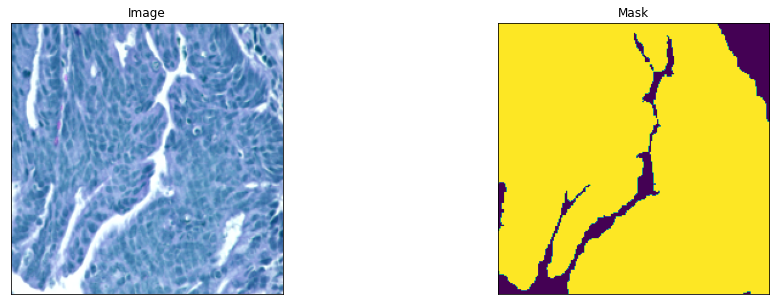

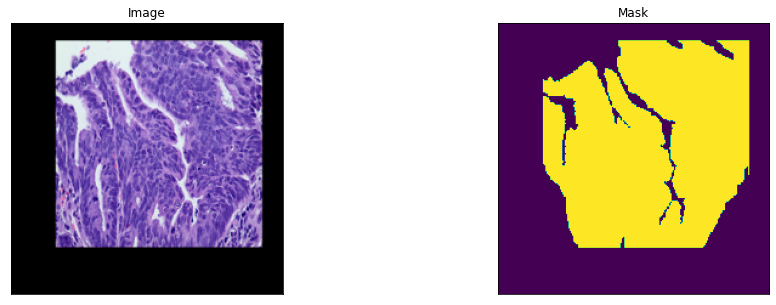

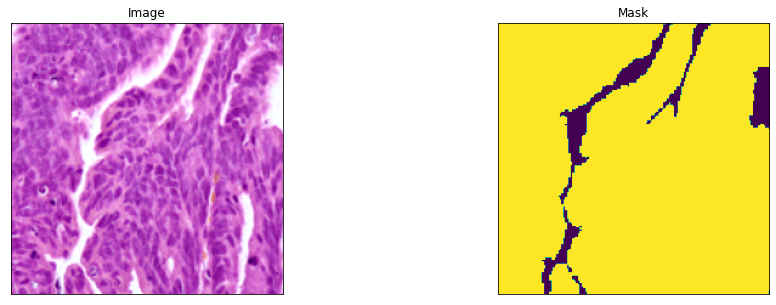

In [17]:
augmented_dataset = Dataset(
    input_train, 
    target_train, 
    augmentation=get_training_augmentation(), 
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze())

In [16]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=None, 
    classes=1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


In [17]:
train_dataset = Dataset(
    input_train, 
    target_train, 
    augmentation=get_training_augmentation(), 
#     augmentation = None,
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = Dataset(
    input_valid, 
    target_valid, 
#     augmentation=get_validation_augmentation(), 
    augmentation = None,
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [18]:
!git clone https://github.com/qubvel/segmentation_models.pytorch/tree/master/segmentation_models_pytorch/utils

Cloning into 'utils'...
fatal: repository 'https://github.com/qubvel/segmentation_models.pytorch/tree/master/segmentation_models_pytorch/utils/' not found


In [19]:
from segmentation_models_pytorch.utils import *

In [20]:
import torch.nn.functional as F
ALPHA = 0.8
GAMMA = 2

class FocalLoss(base.Loss):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

In [21]:
loss = FocalLoss()##### this is smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=3e-4),
])

In [22]:
 optimizer.param_groups[0]['lr']

0.0003

In [23]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [24]:
# free_gpu_cache()
max_score = 0
counter = 0
for i in range(0, 200):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        counter = 0
    counter = counter+1
    if counter > 15:
        break
    if i == 10:
        optimizer.param_groups[0]['lr'] =  optimizer.param_groups[0]['lr']/10
        print('Decrease decoder learning rate to 3e-5!')
    if i == 20:
        optimizer.param_groups[0]['lr'] =  optimizer.param_groups[0]['lr']/10
        print('Decrease learning rate to 3e-6!')


Epoch: 0
valid: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s, focal_loss - 0.1374, iou_score - 0.6666]
Model saved!

Epoch: 1
valid: 100%|██████████| 14/14 [00:07<00:00,  1.97it/s, focal_loss - 0.0616, iou_score - 0.7285] 
Model saved!

Epoch: 2
valid: 100%|██████████| 14/14 [00:07<00:00,  1.97it/s, focal_loss - 0.05262, iou_score - 0.7098]

Epoch: 3
valid: 100%|██████████| 14/14 [00:07<00:00,  1.95it/s, focal_loss - 0.04163, iou_score - 0.7377]
Model saved!

Epoch: 4
valid: 100%|██████████| 14/14 [00:07<00:00,  1.86it/s, focal_loss - 0.03615, iou_score - 0.7536]
Model saved!

Epoch: 5
valid: 100%|██████████| 14/14 [00:07<00:00,  1.92it/s, focal_loss - 0.0523, iou_score - 0.6892] 

Epoch: 6
valid: 100%|██████████| 14/14 [00:07<00:00,  1.96it/s, focal_loss - 0.02119, iou_score - 0.8245]
Model saved!

Epoch: 7
valid: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s, focal_loss - 0.02303, iou_score - 0.8049]

Epoch: 8
valid: 100%|██████████| 14/14 [00:07<00:00,  1.87it/s, focal_loss - 0.

In [25]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')
# best_model = torch.load('/kaggle/input/models-ebhi-seg/best_model(1).pth')

In [26]:
Adenocarcinoma_input = []
Adenocarcinoma_target = []
HIN_input = []
HIN_target = []
LIN_input = []
LIN_target = []
Normal_input = []
Normal_target = []
Polyp_input = []
Polyp_target = []
Serrated_input = []
Serrated_target = []
for (i,t) in zip(input_test,target_test):
    if i.split('/')[5]=='Adenocarcinoma':
        Adenocarcinoma_input.append(i)
        Adenocarcinoma_target.append(t)
    if i.split('/')[5]=='High-grade IN':
        HIN_input.append(i)
        HIN_target.append(t)
    if i.split('/')[5]=='Low-grade IN':
        LIN_input.append(i)
        LIN_target.append(t)
    if i.split('/')[5]=='Normal':
        Normal_input.append(i)
        Normal_target.append(t)
    if i.split('/')[5]=='Polyp':
        Polyp_input.append(i)
        Polyp_target.append(t)
    if i.split('/')[5]=='Serrated adenoma':
        Serrated_input.append(i)
        Serrated_target.append(t)

In [27]:
# create test dataset
test_dataset = Dataset(
    input_test, 
    target_test, 
#     augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

test_dataloader = DataLoader(test_dataset)



In [28]:
# evaluate model on test set
# free_gpu_cache()
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 448/448 [00:11<00:00, 40.72it/s, focal_loss - 0.01707, iou_score - 0.8786]


In [29]:
##Creating test dataset for multiple classes
inputList = [Adenocarcinoma_input,HIN_input,LIN_input,Normal_input,Polyp_input,Serrated_input]
targetList = [Adenocarcinoma_target,HIN_target,LIN_target,Normal_target,Polyp_target,Serrated_target]
diction = {0:'Adeno',1:'HIN',2:'LIN',3:'Normal',4:'Polyp',5:'Serrated'}
k=0
# free_gpu_cache()
for (i,t) in zip(inputList,targetList):
    test_dataset = Dataset(
        i, 
        t, 
    #     augmentation=get_validation_augmentation(), 
        preprocessing=get_preprocessing(preprocessing_fn)
    )

    test_dataloader = DataLoader(test_dataset)

    test_epoch = smp.utils.train.ValidEpoch(
        model=best_model,
        loss=loss,
        metrics=metrics,
        device=DEVICE,
    )
    print(diction[k])
    k=k+1
    logs = test_epoch.run(test_dataloader)

Adeno
valid: 100%|██████████| 159/159 [00:02<00:00, 66.41it/s, focal_loss - 0.03235, iou_score - 0.8416]
HIN
valid: 100%|██████████| 38/38 [00:00<00:00, 64.71it/s, focal_loss - 0.009629, iou_score - 0.8761]
LIN
valid: 100%|██████████| 128/128 [00:02<00:00, 58.83it/s, focal_loss - 0.01056, iou_score - 0.9117]
Normal
valid: 100%|██████████| 16/16 [00:00<00:00, 66.05it/s, focal_loss - 0.008169, iou_score - 0.8957]
Polyp
valid: 100%|██████████| 95/95 [00:01<00:00, 60.60it/s, focal_loss - 0.005341, iou_score - 0.8945]
Serrated
valid: 100%|██████████| 12/12 [00:00<00:00, 63.58it/s, focal_loss - 0.01234, iou_score - 0.8751]


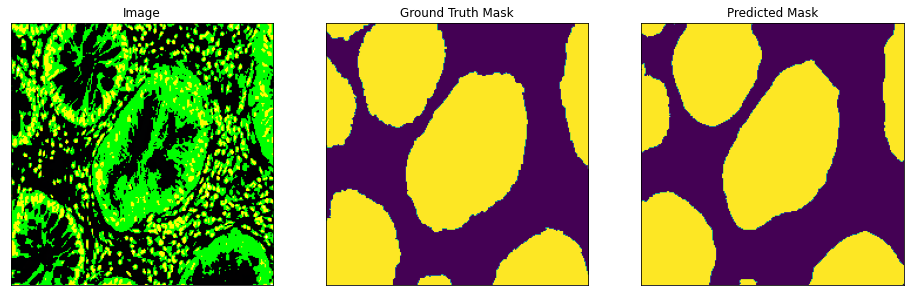

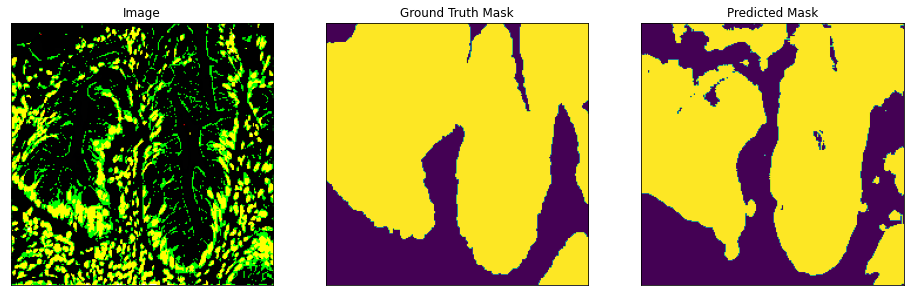

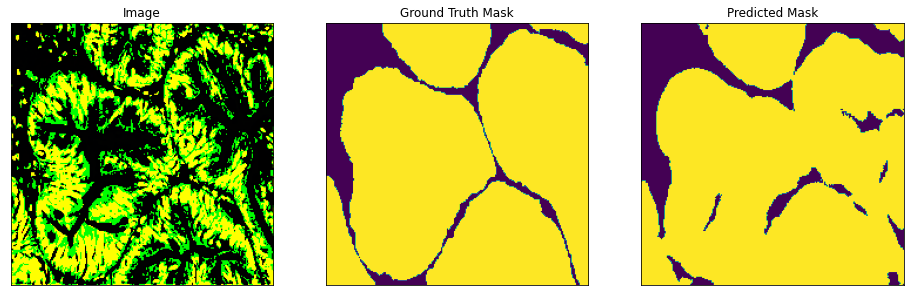

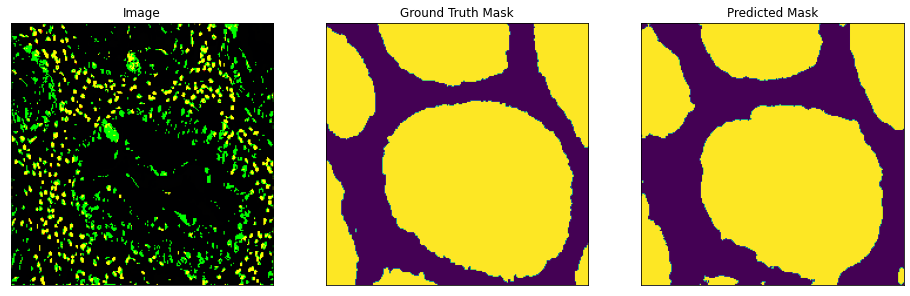

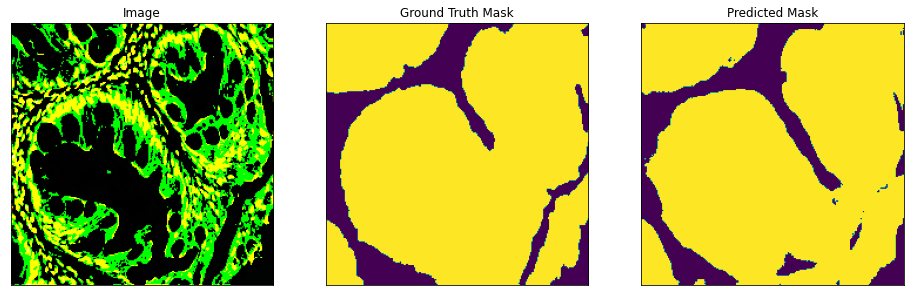

In [30]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis.transpose(1,2,0), 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )